A Jupyter notebook for analyzing the differences between predicted and experimental structures.

In [41]:
from matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
from pandas.plotting import table
import matplotlib.pyplot as plt
import dataframe_image as dfi
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import json
import sys
import scienceplots


Quick look at our data.

In [42]:
cl = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')
rmsd = pd.read_csv('./project_pipeline/data/rmsds.tsv', sep='\t').astype('object')
cl.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,conformation,state,organism,date,notes
0,A0A0R4I961,6gtv,155-279,3-147,1.45,100.0,100.0,1.673,1.135,Open,Active,Escherichia coli F18+,['2018-06-19'],NaN
1,A0A0R4I961,6gtz,155-279,3-147,1.631,100.0,100.0,1.648,3.014,Open,Active,Escherichia coli F18+,['2018-06-19'],NaN
2,A0A0R4I961,6gu0,155-279,3-147,2.105,100.0,100.0,1.788,4.298,Open,Active,Escherichia coli F18+,['2018-06-19'],NaN
3,B5XAZ0,7bfk,116-120,1-115,4.781,100.0,83.478261,2.6,0.965,Closed,Autoinhibited,Salmo salar,['2021-01-04'],NaN
4,B5XAZ0,7bfl,116-120,1-115,2.591,100.0,79.130435,2.76,0.807,Closed,Autoinhibited,Salmo salar,['2021-01-04'],NaN


In [43]:
plt.style.use('science')

# Get the hex codes for the colors so we can assign them to categories
pal = sns.color_palette('Set1')
print(pal.as_hex())

# Set the color palette. Our categories are "Single Domain", "Two-Domain", and "Autoinhibitory"
colors = {'Single Domain': pal[0], 'Two-Domain': pal[1], 'Autoinhibitory': pal[2], 'Full': pal[3], 'Clusters': pal[4]}
pal.as_hex()

['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']


['#e41a1c',
 '#377eb8',
 '#4daf4a',
 '#984ea3',
 '#ff7f00',
 '#ffff33',
 '#a65628',
 '#f781bf',
 '#999999']

We'll re-format the data first.

In [44]:
# Reformat the data for plotting

# Add 1_aligned to classified files
rmsdSub = rmsd[['uniprot', 'pdb', '1_aligned']]
cl = cl.merge(rmsdSub, on=['uniprot', 'pdb'], how='left')

# Select only proteins with both state and conformation annotated
cl = cl.dropna(subset=['state', 'conformation'])
 
# Let's check the length of that
print(len(cl))

# Select columns of interest
clSub = cl[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp']]

# Rename columns
clSub.columns = ['Uniprot', 'PDB', 'Full Sequence', 'IM', 'FD', 'IM on FD']

clSub[['Full Sequence', 'IM', 'FD', 'IM on FD']] = clSub[['Full Sequence', 'IM', 'FD', 'IM on FD']].astype(float)

# Melt the data
plot = pd.melt(clSub, id_vars=['Uniprot', 'PDB'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
plot['RMSD'] = plot['RMSD'].astype(float)

# Remove outliers above 100 RMSD
plot = plot[plot['RMSD'] < 100]

617


/tmp/ipykernel_3239635/3461777564.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clSub[['Full Sequence', 'IM', 'FD', 'IM on FD']] = clSub[['Full Sequence', 'IM', 'FD', 'IM on FD']].astype(float)


# Plot for RMSD of All Autoinhibitory Proteins

First let's look at the distributions for RMSD between whole proteins, inhibitory modules, and functional domains.

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Full Sequence vs. IM: Mann-Whitney-Wilcoxon test two-sided, P_val:1.714e-08 U_stat=2.253e+05
IM vs. FD: Mann-Whitney-Wilcoxon test two-sided, P_val:6.943e-20 U_stat=2.475e+05
FD vs. IM on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.529e-53 U_stat=9.394e+04


Full Sequence vs. FD: Mann-Whitney-Wilcoxon test two-sided, P_val:9.942e-75 U_stat=3.044e+05
IM vs. IM on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:4.976e-16 U_stat=1.393e+05
Full Sequence vs. IM on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:6.326e-03 U_stat=1.727e+05


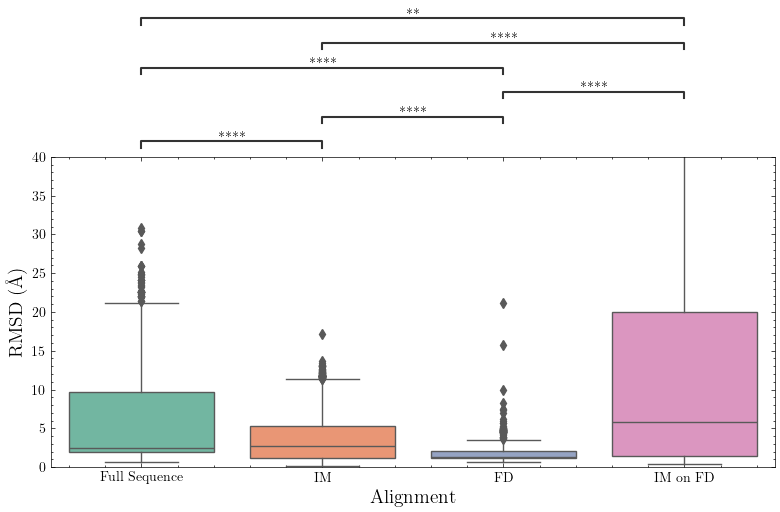

In [45]:
# Now plot it
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=plot, x='Alignment', y='RMSD', ax=ax, palette='Set2')
ax.set_ybound(0.0, 40.0)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)

# Add the annotations
pairs = [('Full Sequence', 'IM'),
         ('Full Sequence', 'FD'),
         ('Full Sequence', 'IM on FD'),
         ('IM', 'FD'),
         ('IM', 'IM on FD'),
         ('FD', 'IM on FD')]
order = ['Full Sequence', 'IM', 'FD', 'IM on FD']
annotator = Annotator(ax, pairs, data=plot, x='Alignment', y='RMSD', order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/rmsd_distributions.png', dpi=300, bbox_inches='tight')

Now let's make a table showing how many AlphaFold2 predictions are in each state.

To do that, we'll first find the experimental structure that has the lowest RMSD for inhibitory modules when aligned on the functional domains.

/tmp/ipykernel_3239635/3894209724.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table(ax, counts.pivot('Predicted State', 'Conformation', 'Count'))


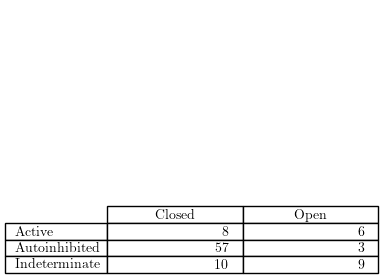

In [46]:
# Find the lowest 2_comp RMSD for each uniprot and keep the PDB identifier
min2Comp = clSub.groupby('Uniprot')[['PDB', 'IM on FD']].min().reset_index()

# Merge the minimum 2_comp RMSD with the original data to get state and conformation
minState = min2Comp.merge(cl[['uniprot', 'pdb', 'state', 'conformation']], left_on='PDB', right_on='pdb')

# Assign predicted structure state. Use state if less than 15 RMSD, otherwise it's 'indeterminate'
minState['predicted_state'] = np.where(minState['IM on FD'] < 15, minState['state'], 'Indeterminate')

# Now let's count the number of proteins in each predicted state and conformation
counts = minState.groupby(['predicted_state', 'conformation']).size().reset_index()
counts.columns = ['Predicted State', 'Conformation', 'Count']

# Let's do it only by predicted state
stateCounts = minState.groupby('predicted_state').size().reset_index()
stateCounts.columns = ['Predicted State', 'Count']

# Let's plot these as tables
ax = plt.subplot(111, frame_on=False)
table(ax, counts.pivot('Predicted State', 'Conformation', 'Count'))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Plot the other one
# ax = plt.subplot(111, frame_on=False)
# table(ax, stateCounts)
# ax.xaxis.set_visible(False)
# ax.yaxis.set_visible(False)

# Save the plot
plt.savefig('./project_pipeline/data/figures/state_conformation_counts.png', dpi=300, bbox_inches='tight')

I also want to look at the correlations between the RMSDs of whole proteins and their regions

Text(0.5, 1.0, 'Full Sequence vs IM on FD')

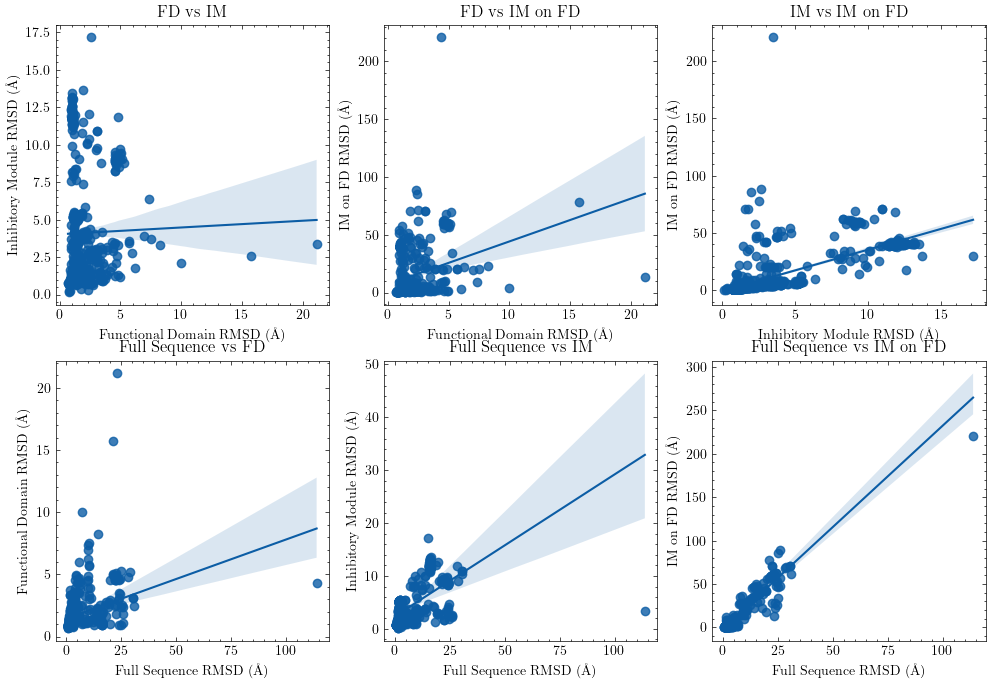

In [47]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

# Correlation of FD to IM
sns.regplot(data=clSub, x='FD', y='IM', ax=ax[0, 0])
ax[0, 0].set_xlabel('Functional Domain RMSD (Å)')
ax[0, 0].set_ylabel('Inhibitory Module RMSD (Å)')
ax[0, 0].set_title('FD vs IM')

# Correlation of FD to IM on FD
sns.regplot(data=clSub, x='FD', y='IM on FD', ax=ax[0, 1])
ax[0, 1].set_xlabel('Functional Domain RMSD (Å)')
ax[0, 1].set_ylabel('IM on FD RMSD (Å)')
ax[0, 1].set_title('FD vs IM on FD')

# Correlation of IM to IM on FD
sns.regplot(data=clSub, x='IM', y='IM on FD', ax=ax[0, 2])
ax[0, 2].set_xlabel('Inhibitory Module RMSD (Å)')
ax[0, 2].set_ylabel('IM on FD RMSD (Å)')
ax[0, 2].set_title('IM vs IM on FD')

# Correlation of Full Sequence to FD
sns.regplot(data=clSub, x='Full Sequence', y='FD', ax=ax[1, 0])
ax[1, 0].set_xlabel('Full Sequence RMSD (Å)')
ax[1, 0].set_ylabel('Functional Domain RMSD (Å)')
ax[1, 0].set_title('Full Sequence vs FD')

# Correlation of Full Sequence to IM
sns.regplot(data=clSub, x='Full Sequence', y='IM', ax=ax[1, 1])
ax[1, 1].set_xlabel('Full Sequence RMSD (Å)')
ax[1, 1].set_ylabel('Inhibitory Module RMSD (Å)')
ax[1, 1].set_title('Full Sequence vs IM')

# Correlation of Complex to IM on FD
sns.regplot(data=clSub, x='Full Sequence', y='IM on FD', ax=ax[1, 2])
ax[1, 2].set_xlabel('Full Sequence RMSD (Å)')
ax[1, 2].set_ylabel('IM on FD RMSD (Å)')
ax[1, 2].set_title('Full Sequence vs IM on FD')

# Plot for RMSD of Two-State Autoinhibitory Proteins

Now let's make the same plots and tables as above for proteins with experimental structures in both states. We'll figure this out _de novo_.

In [48]:
# Determine which proteins from cl have both active and autoinhibited structures
both = cl.groupby('uniprot').filter(lambda x: x['state'].nunique() > 1)

# Format the data for plotting
bothSub = both[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp']]
bothSub.columns = ['Uniprot', 'PDB', 'Full Sequence', 'IM', 'FD', 'IM on FD']
bothPlot = pd.melt(bothSub, id_vars=['Uniprot', 'PDB'], var_name='Alignment', value_name='RMSD')
bothPlot['RMSD'] = bothPlot['RMSD'].astype(float)
bothPlot = bothPlot[bothPlot['RMSD'] < 100]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Full Sequence vs. IM: Mann-Whitney-Wilcoxon test two-sided, P_val:3.222e-01 U_stat=4.345e+04
IM vs. FD: Mann-Whitney-Wilcoxon test two-sided, P_val:5.170e-65 U_stat=7.548e+04
FD vs. IM on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.429e-83 U_stat=2.792e+03
Full Sequence vs. FD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.714e-57 U_stat=7.333e+04
IM vs. IM on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:9.770e-21 U_stat=2.282e+04
Full Sequence vs. IM on FD: Mann-Whitney-Wilcoxon test two-sided, P_val:3.421e-18 U_stat=2.410e+04


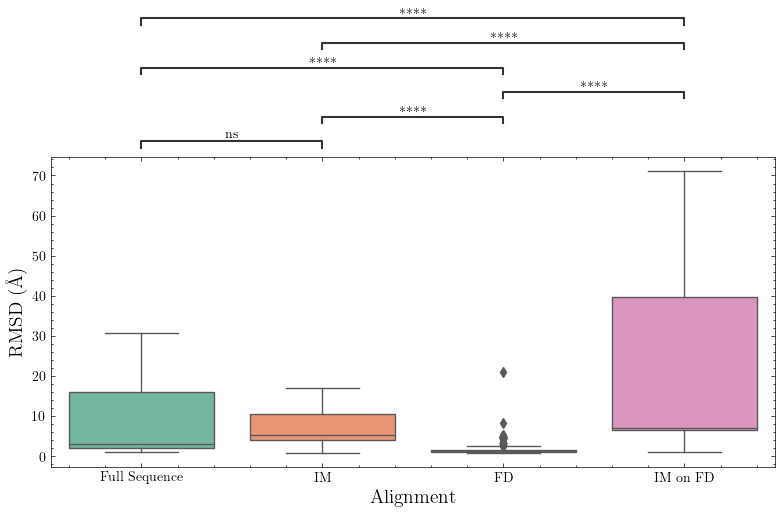

In [49]:
# Plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=bothPlot, x='Alignment', y='RMSD', ax=ax, palette='Set2')
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)

# Add the annotations
pairs = [('Full Sequence', 'IM'),
         ('Full Sequence', 'FD'),
         ('Full Sequence', 'IM on FD'),
         ('IM', 'FD'),
         ('IM', 'IM on FD'),
         ('FD', 'IM on FD')]
order = ['Full Sequence', 'IM', 'FD', 'IM on FD']
annotator = Annotator(ax, pairs, data=bothPlot, x='Alignment', y='RMSD', order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/rmsd_distributions_2state.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_3239635/4238038402.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table(ax, bothCounts.pivot('Predicted State', 'Conformation', 'Count'))


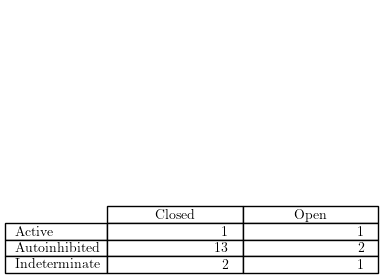

In [50]:
# Now we make the table
bothMin = both.groupby('uniprot')[['pdb', '2_comp']].min().reset_index()

# Merge the minimum 2_comp RMSD with the original data to get state and conformation
bothState = bothMin.merge(both[['uniprot', 'pdb', 'state', 'conformation']], on='pdb')

# Assign predicted structure state. Use state if less than 15 RMSD, otherwise it's 'indeterminate'
bothState['predicted_state'] = np.where(bothState['2_comp'] < 15, bothState['state'], 'Indeterminate')

# Now let's count the number of proteins in each predicted state and conformation
bothCounts = bothState.groupby(['predicted_state', 'conformation']).size().reset_index()
bothCounts.columns = ['Predicted State', 'Conformation', 'Count']

# Make table
ax = plt.subplot(111, frame_on=False)
table(ax, bothCounts.pivot('Predicted State', 'Conformation', 'Count'))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# Save the plot
plt.savefig('./project_pipeline/data/figures/state_conformation_counts_2state.png', dpi=300, bbox_inches='tight')

# Plot for RMSD of Two-Domain Proteins

Now let's look at the distribution of RMSDs for the multi-domain proteins

In [51]:
md = pd.read_csv('./project_pipeline/data/md_rmsds.tsv', sep='\t').astype('object')

# Subset the data
mdSub = md[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp']]

# Rename columns
mdSub.columns = ['Uniprot', 'PDB', 'Full Sequence', 'D1', 'D2', 'D1 on D2']

# Melt the data
mdPlot = pd.melt(mdSub, id_vars=['Uniprot', 'PDB'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
mdPlot['RMSD'] = mdPlot['RMSD'].astype(float)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Full Sequence vs. D1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.189e-08 U_stat=4.758e+04
D1 vs. D2: Mann-Whitney-Wilcoxon test two-sided, P_val:8.428e-01 U_stat=3.763e+04
D2 vs. D1 on D2: Mann-Whitney-Wilcoxon test two-sided, P_val:7.178e-08 U_stat=2.734e+04
Full Sequence vs. D2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.913e-09 U_stat=4.794e+04
D1 vs. D1 on D2: Mann-Whitney-Wilcoxon test two-sided, P_val:2.132e-08 U_stat=2.694e+04
Full Sequence vs. D1 on D2: Mann-Whitney-Wilcoxon test two-sided, P_val:6.238e-01 U_stat=3.636e+04


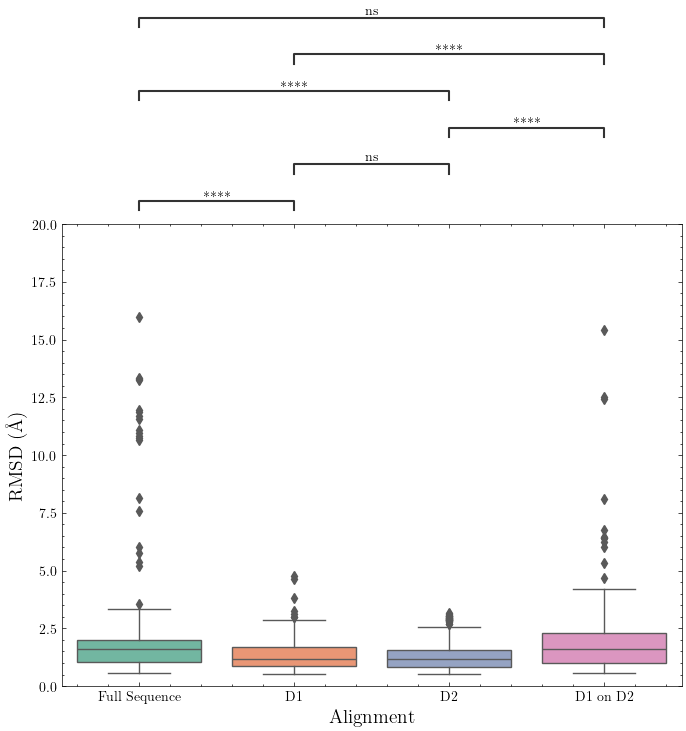

In [52]:
# Now we plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=mdPlot, x='Alignment', y='RMSD', ax=ax, palette='Set2')
ax.set_ybound(0, 20)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)

# Add the annotations
pairs = [('Full Sequence', 'D1'),
         ('Full Sequence', 'D2'),
         ('Full Sequence', 'D1 on D2'),
         ('D1', 'D2'),
         ('D1', 'D1 on D2'),
         ('D2', 'D1 on D2')]
order = ['Full Sequence', 'D1', 'D2', 'D1 on D2']
annotator = Annotator(ax, pairs, data=mdPlot, x='Alignment', y='RMSD', order=order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout
plt.savefig('./project_pipeline/data/figures/md_rmsd_distributions.png', dpi=300, bbox_inches='tight')

# Plot to compare RMSD of Autoinhibitory and Two-Domain Proteins

Now we'll compare between autoinhibitory proteins and Two-Domain proteins.

In [53]:
# Add types to the dataframes
clSub['Type'] = 'Autoinhibitory'
mdSub['Type'] = 'Two-Domain'

# Rename the columns to match
clSub.columns = ['UnipProt', 'PDB', 'Full Sequence', 'IM/D1', 'FD/D2', 'IM on FD/D1 on D2', 'Type']
mdSub.columns = ['UnipProt', 'PDB', 'Full Sequence', 'IM/D1', 'FD/D2', 'IM on FD/D1 on D2', 'Type']

# Concatenate the dataframes
allPlot = pd.concat([clSub, mdSub])

# Melt the data
allPlot = pd.melt(allPlot, id_vars=['UnipProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
allPlot['RMSD'] = allPlot['RMSD'].astype(float)

# Remove outliers
allPlot = allPlot[allPlot['RMSD'] < 100]

/tmp/ipykernel_3239635/3662529167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clSub['Type'] = 'Autoinhibitory'
/tmp/ipykernel_3239635/3662529167.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mdSub['Type'] = 'Two-Domain'


/tmp/ipykernel_3239635/1313441118.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM/D1_Autoinhibitory vs. IM/D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:2.913e-32 U_stat=1.260e+05
Full Sequence_Autoinhibitory vs. Full Sequence_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.948e-43 U_stat=1.327e+05
FD/D2_Autoinhibitory vs. FD/D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.626e-10 U_stat=1.068e+05
IM on FD/D1 on D2_Autoinhibitory vs. IM on FD/D1 on D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:3.324e-27 U_stat=1.222e+05


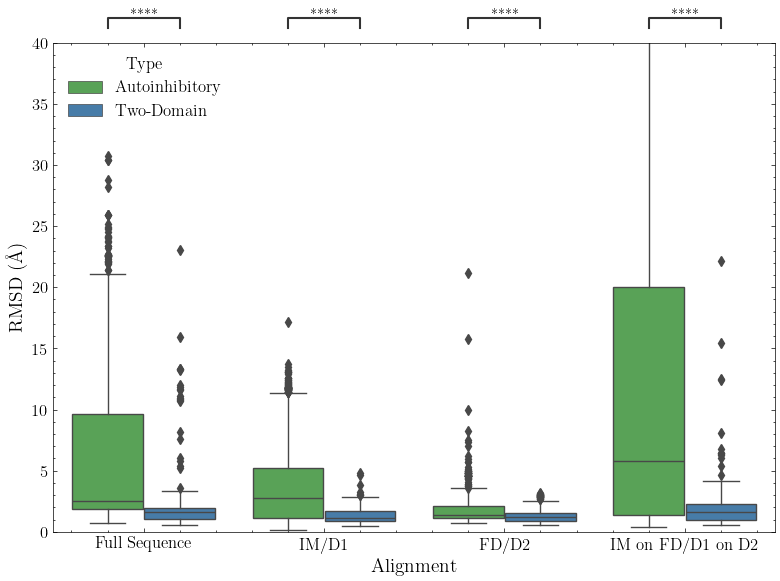

In [54]:
# Now we plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=allPlot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('Full Sequence', 'Autoinhibitory'), ('Full Sequence', 'Two-Domain')],
         [('IM/D1', 'Autoinhibitory'), ('IM/D1', 'Two-Domain')],
         [('FD/D2', 'Autoinhibitory'), ('FD/D2', 'Two-Domain')],
         [('IM on FD/D1 on D2', 'Autoinhibitory'), ('IM on FD/D1 on D2', 'Two-Domain')]]
subcat_order = ['Full Sequence', 'IM/D1', 'FD/D2', 'IM on FD/D1 on D2']
annotator = Annotator(ax, pairs, data=allPlot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/all_rmsd_distributions.png', dpi=300, bbox_inches='tight')

What does our graph look like with only "truly" obligate multi-domain proteins?

In [55]:
si = pd.read_csv('./project_pipeline/data/sidhanta_domains.csv').astype('object')

# Get common proteins between si and md
common = si.merge(md, on='uniprot', how='inner')
common.head()

,uniprot,domains,region_1,region_2,notes,pdb,complex_rmsd,1.0_aligned,1.0_comp,1.1_aligned,...,2.3_aligned,2.3_comp,percent_region_1,percent_region_2,gt_fn,pred_fn,1_aligned,1_comp,2_aligned,2_comp
0,P0AG30,48-123,1-47,48-123,NaN,1a62,1.275,1.041,1.686,0.0,...,0,0,93.617021,100.0,1a62.cif,AF-P0AG30-F1-model_v4.cif,1.041,1.686,1.287,1.239
1,P0AG30,48-123,1-47,48-123,NaN,1a63,3.21,1.994,3.328,0.0,...,0,0,100.0,100.0,1a63.cif,AF-P0AG30-F1-model_v4.cif,1.994,3.328,3.184,2.436
2,P0AG30,48-123,1-47,48-123,NaN,3ice,1.992,1.835,1.875,0.0,...,0,0,61.702128,100.0,3ice.cif,AF-P0AG30-F1-model_v4.cif,1.835,1.875,1.315,2.018
3,P0AG30,48-123,1-47,48-123,NaN,6wa8,3.015,4.644,6.318,0.0,...,0,0,100.0,100.0,6wa8.cif,AF-P0AG30-F1-model_v4.cif,4.644,6.318,1.893,5.339
4,P0AG30,48-123,1-47,48-123,NaN,7x2r,2.462,2.068,1.897,0.0,...,0,0,100.0,100.0,7x2r.cif,AF-P0AG30-F1-model_v4.cif,2.068,1.897,1.722,2.097


In [57]:
# Subset the data
cmSub = common[['uniprot', 'pdb', 'complex_rmsd', '1_aligned', '2_aligned', '2_comp']]

# Rename columns
cmSub.columns = ['Uniprot', 'PDB', 'Full Sequence', 'D1', 'D2', 'D1 on D2']

# Melt the data
cmPlot = pd.melt(cmSub, id_vars=['Uniprot', 'PDB'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
cmPlot['RMSD'] = cmPlot['RMSD'].astype(float)

In [58]:
# Concatenate data
cmSub['Type'] = 'Two-Domain'

cmSub.columns = ['UnipProt', 'PDB', 'Full Sequence', 'IM/D1', 'FD/D2', 'IM on FD/D1 on D2', 'Type']

# Concatenate the dataframes
all2Plot = pd.concat([clSub, cmSub])

# Melt the data
all2Plot = pd.melt(all2Plot, id_vars=['UnipProt', 'PDB', 'Type'], var_name='Alignment', value_name='RMSD')

# Convert the RMSD to a float
all2Plot['RMSD'] = all2Plot['RMSD'].astype(float)

# Remove outliers
all2Plot = all2Plot[all2Plot['RMSD'] < 100]

/tmp/ipykernel_3239635/2951604918.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cmSub['Type'] = 'Two-Domain'


/tmp/ipykernel_3239635/2868461651.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM/D1_Autoinhibitory vs. IM/D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.292e-14 U_stat=6.656e+04
Full Sequence_Autoinhibitory vs. Full Sequence_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:4.798e-32 U_stat=7.652e+04
FD/D2_Autoinhibitory vs. FD/D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:7.962e-05 U_stat=5.726e+04
IM on FD/D1 on D2_Autoinhibitory vs. IM on FD/D1 on D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.361e-19 U_stat=6.979e+04


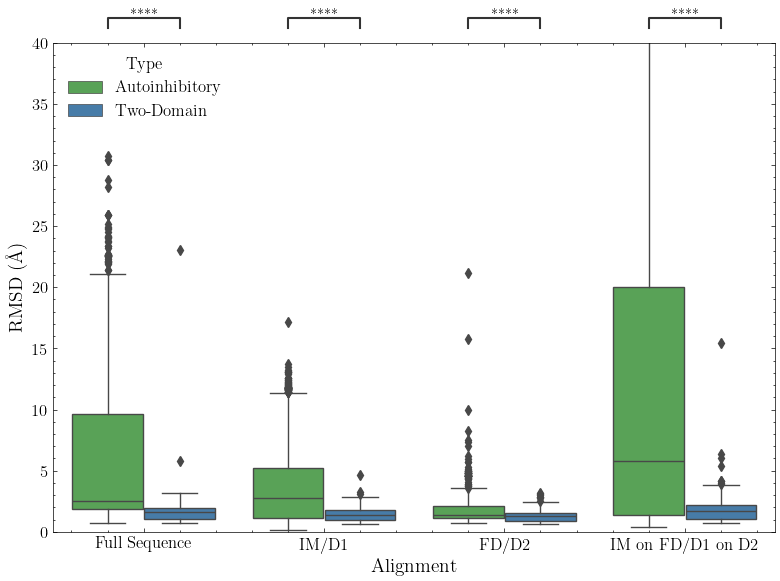

In [59]:
# Now we plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=all2Plot, x='Alignment', y='RMSD', ax=ax, palette=colors, hue='Type')
ax.set_ylim(0, 40)
ax.set_ylabel('RMSD (Å)', fontsize=14)
ax.set_xlabel('Alignment', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
ax.legend(title='Type', fontsize=12, title_fontsize=12)

# Add the annotations, comparing between structural alignment categories
pairs = [[('Full Sequence', 'Autoinhibitory'), ('Full Sequence', 'Two-Domain')],
         [('IM/D1', 'Autoinhibitory'), ('IM/D1', 'Two-Domain')],
         [('FD/D2', 'Autoinhibitory'), ('FD/D2', 'Two-Domain')],
         [('IM on FD/D1 on D2', 'Autoinhibitory'), ('IM on FD/D1 on D2', 'Two-Domain')]]
subcat_order = ['Full Sequence', 'IM/D1', 'FD/D2', 'IM on FD/D1 on D2']
annotator = Annotator(ax, pairs, data=all2Plot, x='Alignment', y='RMSD', order=subcat_order, hue='Type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

# Save the plot
plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/rmsd_distributions_obligate.png', dpi=300, bbox_inches='tight')